In [14]:
# import neccessary libraries
import numpy as np
import random
import sympy as sym
from joblib import Parallel, delayed
from sympy import *
from sympy import symbols
from sympy.plotting import plot, plot3d
from datetime import datetime
import winsound
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz

In [15]:
alpha = Symbol('alpha')
beta= Symbol('beta')
gamma=Symbol('gamma')
theta_0 = Symbol('theta_0')
theta_1 = Symbol('theta_1')
pi=Symbol('pi')

In [16]:
# Function to estimate next hidden state knowing next observation and previous hidden state:
def Pr(xt_,yt,c,param):
    
    alpha_=param[0]
    beta_=param[1]
    gama_=param[2]
    theta_0_=param[3]
    thata_1_=param[4]
    X=np.zeros((n,T))      
        
    if yt==0:
        p0=1-theta_0_
        p1=1-theta_1_
    else:
        p0=theta_0_
        p1=theta_1_
    if xt_==0:
        p0=p0*(1-alpha_)*(1-beta_)**c
        p1=p1*(1-(1-alpha_)*(1-beta_)**c)
    else:
        p0=p0*gama_
        p1=p1*(1-gama_)
      
    return p0,p1               

In [17]:
# Function to calculate emission probability:
def emission(X,Y,n,T):
    
    theta_0 = Symbol('theta_0')
    theta_1 = Symbol('theta_1')
    key=X+2*Y
    pow00=np.count_nonzero(key == 0)
    pow01=np.count_nonzero(key == 1)
    pow10=np.count_nonzero(key == 2)
    pow11=np.count_nonzero(key == 3)
    p=(theta_0)**pow01*(1-theta_0)**pow00*(theta_1)**pow11*(1-theta_1)**pow10
                   
    return sym.log(p)               

In [18]:
# Function to calculate transmition probability:
def transition(X,C,n,T):
    
    alpha = Symbol('alpha')
    beta= Symbol('beta')
    gamma=Symbol('gamma')
    pi=Symbol('pi')
    p=1
    for m in range(n):
        for t in range(T-1):
            if (X[m][t]==0):
                if t==0:
                    p=p*pi
                if (X[m][t+1]==0):
                    p=p*(1-alpha)*(1-beta)**C[m][t]
                else:
                    p=p*(1-(1-alpha)*(1-beta)**C[m][t])
            else: 
                if t==0:
                    p=p*(1-pi)
                if (X[m][t+1]==0):
                    p=p*gamma
                else:
                    p=p*(1-gamma)
        
    return sym.log(p)         
    

In [19]:
# function to count the number of the infected neighbores of i at t:
def CNbr(G,X,n,T):
    C=np.zeros((T,n))
    for t in range(T):
        C[t]=G[t].dot(X.T[t])
    return C.T

In [20]:
# Function to obtain the very initial sample of X, using forwad sampling:
def Forward_Sampling(T,n,G,Y,param):
    
    alpha_=param[0]
    bata_=param[1]
    gama_=param[2]
    theta_0_=param[3]
    thata_1_=param[4] 
    X=np.zeros((n,T))  
    
    for t in range(1,T):
            
        c=G[t-1].dot(X.T[t-1])
        
        for i in range(n):
                    
            pr=Pr(X[i,t-1],Y[i,t],c[i],param)
            p0=pr[0]
            p1=pr[1]
                    
            if p0+p1==0:
                l=0.5
            else:
                l=p1/(p0+p1)
                        
            X[i,t]= np.random.binomial( 1, l,size=None)
                    
        
    return X

In [21]:
# Function to sample new value for x at time t:
def Sample_hidden_state(T,n,X,G,Y,param,t):
    
    alpha_=param[0]
    beta_=param[1]
    gama_=param[2]
    theta_0_=param[3]
    thata_1_=param[4]
    
    pow_stay_healthy,pow_become_infected,pow_recovery,pow_stay_infected=0,0,0,0
    
    if (t==0):
        c=G[t].dot(X.T[t])
    else:    
        c=G[t-1].dot(X.T[t-1])
        
    for i in range(n):
        
        if Y[i,t]==0:
            p0=1-theta_0_
            p1=1-theta_1_
        else:
            p0=theta_0_
            p1=theta_1_
            
        if (X[i,t]==1)&(t==0):
            c0=c[i]-1
            c1=c[i]
        else:
            c0=c[i]
            c1=c[i]+1
                
        stay_healthy0=(1-alpha_)*(1-beta_)**c0
        become_infected0=1-(1-alpha_)*(1-beta_)**c0
    
        stay_healthy1=(1-alpha_)*(1-beta_)**c1
        become_infected1=1-(1-alpha_)*(1-beta_)**c1
        
        if t==T-1:
            if X[i,t-1]==0:
                p0=p0*stay_healthy0
                p1=p1*become_infected0
            else:
                p0=p0*gama_
                p1=p1*(1-gama_) 
        else:        
            state_transition=X.T[t]+2*X.T[t+1]+1
            key=np.multiply(G[0][i],state_transition)
    
            pow_stay_healthy=pow_stay_healthy+np.count_nonzero(key == 4)
            pow_become_infected=pow_become_infected+np.count_nonzero(key == 3)
            pow_recovery=pow_recovery+np.count_nonzero(key == 2)
            pow_stay_infected=pow_stay_infected+np.count_nonzero(key ==1)
    

    
            p0=p_*p0*(stay_healthy0)**pow_stay_healthy*(become_infected0)**pow_become_infected*(gama_)**pow_recovery*(1-gama_)**pow_stay_infected
            p1=(1-p_)*p1*(stay_healthy1)**pow_stay_healthy*(become_infected1)**pow_become_infected*(gama_)**pow_recovery*(1-gama_)**pow_stay_infected
            
        if p0+p1==0:
            l=0.5
        else:
            l=p1/(p0+p1)
        X[i,0]=np.random.binomial( 1,  l,size=None)    
        
    return X       

In [22]:
# Gibbs sampling to obtain X, as new sample of posterior distribution:
def Calculate_X(K,T,n,X,G,Y,param):

    alpha_=param[0]
    beta_=param[1]
    gama_=param[2]
    theta_0_=param[3]
    thata_1_=param[4]
    
    for k in range(K):
        for t in range(T):
            X=Sample_hidden_state(T,n,X,G,Y,param,t)
    return X                

In [12]:
# Download preprocessed social evolution dataset, 
%store -r Y
%store -r G
Y1=np.logical_or(np.logical_or(np.logical_or(Y[0],Y[1]),np.logical_or(Y[2],Y[3])),np.logical_or(Y[4],Y[5]))+0

In [14]:
####### randomly initialize parameters:

n=63
T=66
 # number of samples
J=10

 # number of iterations in Gibbs Sampling algorithm 
K=1000

 # number of iterations in MCEM
r=10

alpha_=0.005
beta_=0.045
gama_=0.3
theta_0_=0.01
theta_1_=0.9
p_=0.9

params=[]
params.append([alpha_,beta_,gama_,theta_0_,theta_1_,p_])

In [83]:
# MCEM to estimate X and parameters:
for i in range(r):
    print("MCEM #iteration:",i)
    X=Forward_Sampling(T,n,G,Y1,params[-1])
    Q=0
    for j in range(J):
        print(" #Samples Generated in GibbsSampling:",j)
        X=Calculate_X(K,T,n,X,G,Y1,params[-1])
        print("Verctor of Health States:","\n",X)
        print(np.sum(X))
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
        Q=np.sum(np.array(transition(X,CNbr(G,X,n,T),n,T))+emission(X,Y1,n,T),axis=0)+Q    
    a=round(float(solve(simplify(Q.diff(theta_0)))[0]),3)
    b=round(float(solve(simplify(Q.diff(theta_1)))[0]),3)
    ga=round(float(solve(simplify(factor(Q.diff(gamma))))[0]),3)
    o=Q.subs(theta_0,a).subs(theta_1,b).subs(gamma,ga)
    o=expand_log(o, force=True)
    p_=round(float(solve(o.diff(pi))[0]),3)
    o=o.subs(pi,p_)
    alta=nsolve((o.diff(alpha),o.diff(beta)),(alpha,beta),(alpha_,beta_))
#******************************update parameters
    alpha_=round(alta[0],3)
    beta_=round(alta[1],3)
    gama_=ga
    theta_0_=a
    theta_1_=b
    params.append([alpha_,beta_,gama_,theta_0_,theta_1_,p_])
    winsound.Beep(freq, duration)
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time is :", current_time)
    print("New parameters:",alpha_,beta_,gama_,theta_0_,theta_1_,p_)
    print("Verctor of Health States:","\n",X)
    print(np.sum(X))

MCEM #iteration: 0
 #Samples Generated in GibbsSampling: 0
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
920.0
Current Time is : 12:05:47
 #Samples Generated in GibbsSampling: 1
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
920.0
Current Time is : 13:03:04
 #Samples Generated in GibbsSampling: 2
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
916.0
Current Time is : 14:00:25
 #Samples Generated in GibbsSampling: 3
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. .

Current Time is : 15:51:04
New parameters: 0.070 0.013 0.263 0.064 0.757 0.751
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
918.0
MCEM #iteration: 3
 #Samples Generated in GibbsSampling: 0
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
918.0
Current Time is : 16:51:15
 #Samples Generated in GibbsSampling: 1
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
917.0
Current Time is : 17:50:34
 #Samples Generated in GibbsSampling: 2
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]


 #Samples Generated in GibbsSampling: 9
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
917.0
Current Time is : 22:12:35
Current Time is : 22:12:58
New parameters: 0.070 0.013 0.263 0.064 0.757 0.763
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
917.0
MCEM #iteration: 6
 #Samples Generated in GibbsSampling: 0
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
918.0
Current Time is : 23:13:35
 #Samples Generated in GibbsSampling: 1
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]


 #Samples Generated in GibbsSampling: 8
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
920.0
Current Time is : 03:33:54
 #Samples Generated in GibbsSampling: 9
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
920.0
Current Time is : 04:31:22
Current Time is : 04:31:39
New parameters: 0.070 0.013 0.263 0.064 0.757 0.751
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
920.0
MCEM #iteration: 9
 #Samples Generated in GibbsSampling: 0
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]


In [16]:
for i in range(r):
    print("MCEM #iteration:",i)
    X=Forward_Sampling(T,n,G,Y1,params[-1])
    Q=0
    for j in range(J):
        print(" #Samples Generated in GibbsSampling:",j)
        X=Calculate_X(K,T,n,X,G,Y1,params[-1])
        print("Verctor of Health States:","\n",X)
        print(np.sum(X))
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
        Q=np.sum(np.array(transition(X,CNbr(G,X,n,T),n,T))+emission(X,Y1,n,T),axis=0)+Q    
    a=round(float(solve(simplify(Q.diff(theta_0)))[0]),3)
    b=round(float(solve(simplify(Q.diff(theta_1)))[0]),3)
    ga=round(float(solve(simplify(factor(Q.diff(gamma))))[0]),3)
    o=Q.subs(theta_0,a).subs(theta_1,b).subs(gamma,ga)
    o=expand_log(o, force=True)
    p_=round(float(solve(o.diff(pi))[0]),3)
    o=o.subs(pi,p_)
    alta=nsolve((o.diff(alpha),o.diff(beta)),(alpha,beta),(alpha_,beta_))
#******************************update parameters
    alpha_=round(alta[0],3)
    beta_=round(alta[1],3)
    gama_=ga
    theta_0_=a
    theta_1_=b
    params.append([alpha_,beta_,gama_,theta_0_,theta_1_,p_])
    winsound.Beep(freq, duration)
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time is :", current_time)
    print("New parameters:",alpha_,beta_,gama_,theta_0_,theta_1_,p_)
    print("Verctor of Health States:","\n",X)
    print(np.sum(X))

MCEM #iteration: 0
 #Samples Generated in GibbsSampling: 0
Verctor of Health States: 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
775.0
Current Time is : 18:09:58
 #Samples Generated in GibbsSampling: 1
Verctor of Health States: 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
777.0
Current Time is : 18:13:29
 #Samples Generated in GibbsSampling: 2
Verctor of Health States: 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
774.0
Current Time is : 18:17:00
 #Samples Generated in GibbsSampling: 3
Verctor of Health States: 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. .

Current Time is : 14:15:10
New parameters: 0.058 0.051 0.277 0.053 0.741 0.784
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
866.0
MCEM #iteration: 3
 #Samples Generated in GibbsSampling: 0
Verctor of Health States: 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1014.0
Current Time is : 15:13:01
 #Samples Generated in GibbsSampling: 1
Verctor of Health States: 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1010.0
Current Time is : 16:10:32
 #Samples Generated in GibbsSampling: 2
Verctor of Health States: 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.

 #Samples Generated in GibbsSampling: 9
Verctor of Health States: 
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
960.0
Current Time is : 19:27:40
Current Time is : 19:27:57
New parameters: 0.061 0.026 0.233 0.077 0.759 0.713
Verctor of Health States: 
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
960.0
MCEM #iteration: 6
 #Samples Generated in GibbsSampling: 0
Verctor of Health States: 
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
940.0
Current Time is : 20:24:05
 #Samples Generated in GibbsSampling: 1
Verctor of Health States: 
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]


 #Samples Generated in GibbsSampling: 8
Verctor of Health States: 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 1.]]
984.0
Current Time is : 22:18:03
 #Samples Generated in GibbsSampling: 9
Verctor of Health States: 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]
985.0
Current Time is : 23:11:49
Current Time is : 23:12:06
New parameters: 0.074 0.023 0.264 0.078 0.776 0.775
Verctor of Health States: 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]
985.0
MCEM #iteration: 9
 #Samples Generated in GibbsSampling: 0
Verctor of Health States: 
 [[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]


In [99]:
params

[[0.005, 0.045, 0.3, 0.01, 0.9, 0.9],
 [0.04, 0.055, 0.244, 0.023, 0.746, 0.814],
 [0.061, 0.051, 0.227, 0.08, 0.855, 0.721],
 [0.058, 0.051, 0.277, 0.053, 0.741, 0.784],
 [0.067, 0.047, 0.257, 0.081, 0.8, 0.733],
 [0.061, 0.029, 0.259, 0.059, 0.733, 0.746],
 [0.061, 0.026, 0.233, 0.077, 0.759, 0.713],
 [0.067, 0.03, 0.263, 0.075, 0.745, 0.757],
 [0.061, 0.027, 0.238, 0.065, 0.773, 0.79],
 [0.074, 0.023, 0.264, 0.078, 0.776, 0.775],
 [0.07, 0.013, 0.263, 0.064, 0.757, 0.751],
 [0.07, 0.013, 0.263, 0.064, 0.757, 0.754],
 [0.07, 0.013, 0.263, 0.064, 0.757, 0.754],
 [0.07, 0.013, 0.263, 0.064, 0.757, 0.751],
 [0.07, 0.013, 0.262, 0.064, 0.757, 0.768],
 [0.07, 0.013, 0.264, 0.064, 0.757, 0.744],
 [0.07, 0.013, 0.263, 0.064, 0.757, 0.763],
 [0.07, 0.013, 0.263, 0.064, 0.757, 0.765],
 [0.07, 0.013, 0.263, 0.064, 0.757, 0.759],
 [0.07, 0.013, 0.263, 0.064, 0.757, 0.751],
 [0.07, 0.013, 0.263, 0.064, 0.757, 0.762]]

In [85]:
Q

3*log(theta_0**204*theta_1**712*(1 - theta_0)**3013*(1 - theta_1)**229) + log(theta_0**206*theta_1**711*(1 - theta_0)**3011*(1 - theta_1)**230) + 2*log(theta_0**206*theta_1**712*(1 - theta_0)**3011*(1 - theta_1)**229) + 2*log(theta_0**207*theta_1**712*(1 - theta_0)**3010*(1 - theta_1)**229) + log(theta_0**208*theta_1**712*(1 - theta_0)**3009*(1 - theta_1)**229) + log(theta_0**209*theta_1**712*(1 - theta_0)**3008*(1 - theta_1)**229) + log(alpha**177*gamma**238*pi**46*(1 - alpha)**2954*(1 - beta)**994.0*(1 - gamma)**666*(1 - pi)**17*(-(1 - alpha)*(1 - beta)**1.0 + 1)**31*(-(1 - alpha)*(1 - beta)**2.0 + 1)**16*(-(1 - alpha)*(1 - beta)**3.0 + 1)**10*(-(1 - alpha)*(1 - beta)**4.0 + 1)**3) + log(alpha**178*gamma**235*pi**50*(1 - alpha)**2957*(1 - beta)**994.0*(1 - gamma)**665*(1 - pi)**13*(-(1 - alpha)*(1 - beta)**1.0 + 1)**31*(-(1 - alpha)*(1 - beta)**2.0 + 1)**16*(-(1 - alpha)*(1 - beta)**3.0 + 1)**10*(-(1 - alpha)*(1 - beta)**4.0 + 1)**3) + log(alpha**178*gamma**235*pi**50*(1 - alpha)**29

In [3]:
#params[-1]

In [ ]:
#Now that the MCEM algorithm has converged, we use obitimized params to synthetize data for n=100 and T=100:

In [23]:
# Choose some params close to obtimized params:
alpha_= 0.05
beta_= 0.01
gama_= 0.3
theta_0_= 0.07
theta_1_= 0.8
p_= 0.8
params=[]
params.append([alpha_,beta_,gama_,theta_0_,theta_1_,p_])

In [24]:
# Function to generates Synthetic dataset
def Synthetic_Data(n,T,y,params):
    alpha_,beta_,gama_,theta_0_,theta_1_,p_=params[0],params[1],params[2],params[3],params[4],params[5]
    x=int((1-p_)*n)

    X=np.zeros((n,T))
    idx=np.random.choice(range(n), x)
    X[idx,0]=1
    # Random social network
    G=[]
    for j in range(T):
        g=np.identity(n)
        for i in range(n):
            inx=np.random.choice(range(i,n), y)
            g[i,inx]=1  
            g[inx,i]=1
        G.append(g)
    G=np.array(G)
    infR=CNbr(G,X,n,T)
    # Synthetize X, using params,G and transition probability:
    for t in range(T-1):
        for i in range(n):
            c=infR[i,t]
            if X[i,t]==0:
                p0=(1-alpha_)*(1-beta_)**c
                p1=1-(1-alpha_)*(1-beta_)**c
            else:
                p0=gama_
                p1=1-gama_
            if p0+p1==0:
                l=0.5
            else:
                l=p1/(p0+p1)
            X[i,t+1]=np.random.binomial( 1, l,size=None) 

    # Synthetize Y, using params,G, X, emission probability:
    Y=np.zeros((n,T))
    for t in range(T):
        for i in range(n):
            if X[i,t]==0:
                Y[i,t]=np.random.binomial( 1, theta_0_,size=None) 
            else:
                Y[i,t]=np.random.binomial( 1, theta_1_,size=None) 
    return G,Y,X            

In [25]:
params[0]

[0.05, 0.01, 0.3, 0.07, 0.8, 0.8]

In [26]:
n,T,y=100,100,10
synthetic_data=Synthetic_Data(n,T,y,params[-1])
G,Y,X =synthetic_data[0],synthetic_data[1],synthetic_data[2]

In [29]:
print(np.sum(G),np.sum(X),np.sum(Y))

174724.0 1438.0 1715.0


In [30]:
# Save true value of X in Z, as the correct label of data:
Z=X
np.sum(Z)

1438.0

In [ ]:
# Run our MCEM algorithm to estimate X:
r=10
K=1000
J=10

for i in range(r):
    print("MCEM #iteration:",i)
    print("new parameters:",params[-1])
    X=Forward_Sampling(T,n,G,Y,params[-1])
    Q=0
    for j in range(J):
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)      
        print(" #Samples Generated in GibbsSampling:",j)
        X=Calculate_X(K,T,n,X,G,Y,params[-1])

        print("Verctor of Health States:","\n",X)
        print("#zeros in X:",np.sum(X))
        Q=np.sum(np.array(transition(X,CNbr(G,X,n,T),n,T))+emission(X,Y,n,T),axis=0)+Q    
    a=round(float(solve(simplify(Q.diff(theta_0)))[0]),3)
    b=round(float(solve(simplify(Q.diff(theta_1)))[0]),3)
    ga=round(float(solve(simplify(factor(Q.diff(gamma))))[0]),3)
    o=Q.subs(theta_0,a).subs(theta_1,b).subs(gamma,ga)
    o=expand_log(o, force=True)
    p_=round(float(solve(o.diff(pi))[0]),3)
    o=o.subs(pi,p_)
    alta=nsolve((o.diff(alpha),o.diff(beta)),(alpha,beta),(alpha_,beta_))
#******************************update parameters
    alpha_=round(alta[0],3)
    beta_=round(alta[1],3)
    gama_=ga
    theta_0_=a
    theta_1_=b
    params.append([alpha_,beta_,gama_,theta_0_,theta_1_,p_])
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time is :", current_time)
    print("New parameters:",alpha_,beta_,gama_,theta_0_,theta_1_,p_)
    print("Verctor of Health States:","\n",X)
    print("#zeros in X:",np.sum(X))


MCEM #iteration: 0
new parameters: [0.05, 0.01, 0.3, 0.07, 0.8, 0.8]
Current Time is : 21:38:16
 #Samples Generated in GibbsSampling: 0
Verctor of Health States: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 1.]]
#zeros in X: 2026.0
Current Time is : 21:46:40
 #Samples Generated in GibbsSampling: 1
Verctor of Health States: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 1.]]
#zeros in X: 2027.0
Current Time is : 21:55:10
 #Samples Generated in GibbsSampling: 2
Verctor of Health States: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 1.]]
#zeros in X: 2030.0
Current Time is : 22:04:08
 #Samples Generated in GibbsSampling: 3
Verctor of Health States: 
 [[0. 0. 0. ... 0. 0. 0.

In [ ]:
# Compare X, Z and estimate accuracy of the model:

In [142]:
# synthetized observation vectore:
Y_=np.zeros((n,T))
for t in range(T):
    for i in range(n):
        if X[i,t]==0:
            Y_[i,t]=np.random.binomial( 1, theta_0_,size=None) 
        else:
            Y_[i,t]=np.random.binomial( 1, theta_1_,size=None) 

[0.07, 0.013, 0.263, 0.064, 0.757, 0.762]

In [87]:
r=10
K=1000
J=10

# test the model with synthetized data, Y_,G:
for i in range(r):
    print("MCEM #iteration:",i)
    X=Forward_Sampling(T,n,G,Y_,params[-1])
    Q=0
    for j in range(J):
        print(" #Samples Generated in GibbsSampling:",j)
        X=Calculate_X(K,T,n,X,G,Y_,params[-1])
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
        print("Verctor of Health States:","\n",X)
        print(np.sum(X))
        Q=np.sum(np.array(transition(X,CNbr(G,X,n,T),n,T))+emission(X,Y_,n,T),axis=0)+Q    
    a=round(float(solve(simplify(Q.diff(theta_0)))[0]),3)
    b=round(float(solve(simplify(Q.diff(theta_1)))[0]),3)
    ga=round(float(solve(simplify(factor(Q.diff(gamma))))[0]),3)
    o=Q.subs(theta_0,a).subs(theta_1,b).subs(gamma,ga)
    o=expand_log(o, force=True)
    p_=round(float(solve(o.diff(pi))[0]),3)
    o=o.subs(pi,p_)
    alta=nsolve((o.diff(alpha),o.diff(beta)),(alpha,beta),(alpha_,beta_))
#******************************update parameters
    alpha_=round(alta[0],3)
    beta_=round(alta[1],3)
    gama_=ga
    theta_0_=a
    theta_1_=b
    params.append([alpha_,beta_,gama_,theta_0_,theta_1_,p_])
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time is :", current_time)
    print("New parameters:",alpha_,beta_,gama_,theta_0_,theta_1_,p_)
    print("Verctor of Health States:","\n",X)

np.sum(X)

433

In [88]:
np.size(X)

4158

In [89]:
np.sum(Y1)

941

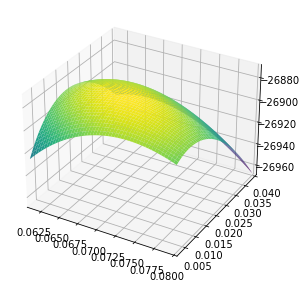

In [90]:
plot3d(o,(alpha,.061,.08),(beta,0.001999,0.04009))

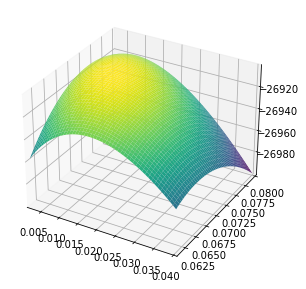

In [39]:
plot3d(o,(beta,0.001999,0.04009),(alpha,.061,.08))

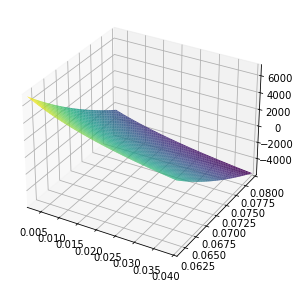

In [41]:
plot3d(o.diff(alpha),(beta,0.001999,0.04009),(alpha,.061,.08))

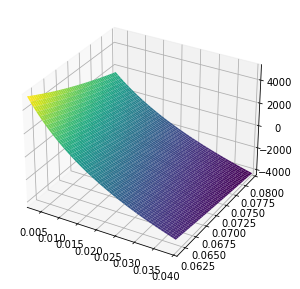

In [42]:
plot3d(o.diff(beta),(beta,0.001999,0.04009),(alpha,.061,.08))

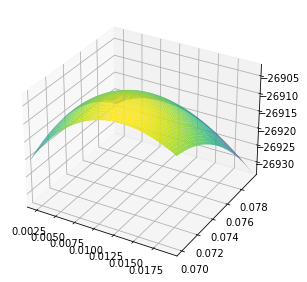

In [82]:
plot3d(o,(beta,.00161,.01999908),(alpha,.06961,.079949799908))

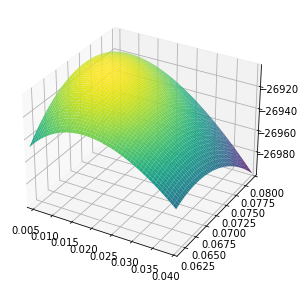

In [57]:
plot3d(o,(beta,0.0041999,0.04009),(alpha,.061,.08))

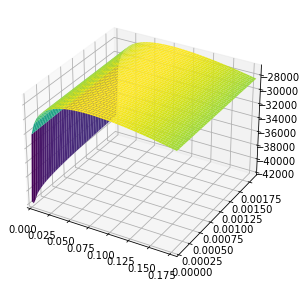

In [55]:
plot3d(o,(alpha,-.000061,.18),(beta,-0.00000041999,0.0019))

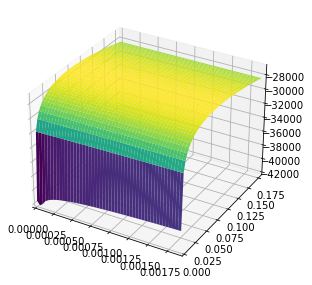

In [54]:
plot3d(o,(beta,-0.00000041999,0.0019),(alpha,-.000061,.18))

# ##############################################################################################################################

In [ ]:
# The following is for family test result problem:

In [44]:
# Randomly initialize params:
number_families=30
alpha_=0.005
beta_=0.045 
gama_=0.3
theta_0_=0.01
theta_1_=0.9
p_=0.9

params=[]
params.append([alpha_,beta_,gama_,theta_0_,theta_1_,p_])

# Synthetize data for famity test result problem

In [32]:
# Synthetize the "Family" matrix, which denotes that each two individuals are in the same family or not:
a=list(range(n))
Family=np.identity(n)
for i in range(1,number_families):
    number_family_members=np.random.randint(2, 5)
    inx=random.sample(list(a), number_family_members)
    a=set(a).difference(inx)
    for j in inx:
        for k in inx:
            Family[j,k]=1
Family

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [33]:
# Synthetize G,Y,X:
n,T,y=100,100,10
synthetic_data=Synthetic_Data(n,T,y,params[-1])
G,Y,X =synthetic_data[0],synthetic_data[1],synthetic_data[2]

In [34]:
# synthetize family test result matrix,YF:
unique_rows = np.unique(Family, axis=0)
unique_rows.shape
YF=np.zeros((n,T))
YF=np.dot(unique_rows,Y)
YF.shape

(36, 100)

# Simulation data is ready now, YF,G,Family:

In [37]:
# number of neighbore in family
neighbore_family=[]
for t in range(T):
    neighbore_family.append(np.dot(unique_rows,G[t]))
neighbore_family=np.array(neighbore_family)

neighbore_family.shape

(100, 36, 100)

In [38]:
#number_infected_neighbores for each individual i at each time t:
number_infected_neighbore=[]
for t in range(T):
    number_infected_neighbore.append(np.dot(neighbore_family[t].T,YF.T[t].T))

number_infected_neighbore=np.array(number_infected_neighbore)
number_infected_neighbore.shape

(100, 100)

In [39]:
# number_infected_neighbores for each member of each family at each time::
infected_neighbore_of_family_members=[]
for t in range(T):
    infected_neighbore_of_family_members.append(np.multiply(unique_rows,number_infected_neighbore[t]))
infected_neighbore_of_family_members=np.array(infected_neighbore_of_family_members)  

infected_neighbore_of_family_members.shape

(100, 36, 100)

In [40]:
# generate synthetized Y_, which is our sudo observation matrix:
Y_=np.zeros((n,T))
for i in range(number_families):
    for t in range(T):
        an_array=infected_neighbore_of_family_members[t][i]
        indx = np.argsort(an_array)[-2:]
        if len(indx)>0:
            Y_[indx,t]=1
Y_


np.sum(Y_)

4393.0

#  Now we have sudo observation matrix Y_ and social network G, so  we do estimate X and parameters for these synthetic dataset:


In [48]:
r=10
K=1000
J=1

# test the model with synthetized data, Y_,G:
for i in range(r):
    print("MCEM #iteration:",i)
    X=Forward_Sampling(T,n,G,Y_,params[-1])
    Q=0
    for j in range(J):
        print(" #Samples Generated in GibbsSampling:",j)
        X=Calculate_X(K,T,n,X,G,Y_,params[-1])
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
        print("Verctor of Health States:","\n",X)
        print(np.sum(X))
        Q=np.sum(np.array(transition(X,CNbr(G,X,n,T),n,T))+emission(X,Y_,n,T),axis=0)+Q    
    a=round(float(solve(simplify(Q.diff(theta_0)))[0]),3)
    b=round(float(solve(simplify(Q.diff(theta_1)))[0]),3)
    ga=round(float(solve(simplify(factor(Q.diff(gamma))))[0]),3)
    o=Q.subs(theta_0,a).subs(theta_1,b).subs(gamma,ga)
    o=expand_log(o, force=True)
    p_=round(float(solve(o.diff(pi))[0]),3)
    o=o.subs(pi,p_)
    alta=nsolve((o.diff(alpha),o.diff(beta)),(alpha,beta),(alpha_,beta_))
#******************************update parameters
    alpha_=round(alta[0],3)
    beta_=round(alta[1],3)
    gama_=ga
    theta_0_=a
    theta_1_=b
    params.append([alpha_,beta_,gama_,theta_0_,theta_1_,p_])
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time is :", current_time)
    print("New parameters:",alpha_,beta_,gama_,theta_0_,theta_1_,p_)
    print("Verctor of Health States:","\n",X)

np.sum(X)

MCEM #iteration: 0
 #Samples Generated in GibbsSampling: 0
Current Time is : 12:59:52
Verctor of Health States: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 1.]]
4755.0
Current Time is : 13:01:07
New parameters: 0.201 0.023 0.349 0.097 0.958 0.9
Verctor of Health States: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 1.]]
MCEM #iteration: 1
 #Samples Generated in GibbsSampling: 0


KeyboardInterrupt: 

In [47]:
params[-1]

[0.005, 0.045, 0.3, 0.01, 0.9, 0.9]